In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import random

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import GridSearchCV
import warnings

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

train_1 = pd.read_csv('train (1).csv')
train = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

#### Посмотрим на все данные что они из себя представляют, сколько пропусков, какие новые данные появились 

In [2]:
def first_Data(Data):
    print("DATA")
    print(Data.info())
    print('ISNULL')
    print(Data.isnull().sum())
    print("Head")
    print(Data.head())
    print('-----------------------------------------------------------------------')

In [3]:
first_Data(train_1)    
first_Data(train)
first_Data(submission)
first_Data(test) 

DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
client_id           73799 non-null int64
education           73492 non-null object
sex                 73799 non-null object
age                 73799 non-null int64
car                 73799 non-null object
car_type            73799 non-null object
decline_app_cnt     73799 non-null int64
good_work           73799 non-null int64
bki_request_cnt     73799 non-null int64
home_address        73799 non-null int64
work_address        73799 non-null int64
income              73799 non-null int64
foreign_passport    73799 non-null object
default             73799 non-null int64
dtypes: int64(9), object(5)
memory usage: 7.9+ MB
None
ISNULL
client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_

In [4]:
print(len(train_1))
print(len(train))
print(len(test))
print(len(submission))

73799
73799
36349
24354


### Становиться понятно, что нужно совместить старые данные (train_1) c новыми данными (test), по столбцу client_id 

In [5]:
data_train = train.merge(train_1, how='outer')
data_train['sample'] = 1
test['sample'] = 0
test['default'] = 0 
data = test.append(data_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,1,0
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,1,0
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,1,0
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,1


### Посмотри что у нас получилось 

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

#### Проверим в каких столбцах сколько пропусков 

In [7]:
NaN_Sum = lambda col: col.isnull().sum()  # Функция для определения количества нулевых знчений  
columns = list(data.columns)
for col in columns:
    print("Количество пустых значений", col, NaN_Sum(data[col]), sep=' ')

Количество пустых значений client_id 0
Количество пустых значений app_date 0
Количество пустых значений education 478
Количество пустых значений sex 0
Количество пустых значений age 0
Количество пустых значений car 0
Количество пустых значений car_type 0
Количество пустых значений decline_app_cnt 0
Количество пустых значений good_work 0
Количество пустых значений score_bki 0
Количество пустых значений bki_request_cnt 0
Количество пустых значений region_rating 0
Количество пустых значений home_address 0
Количество пустых значений work_address 0
Количество пустых значений income 0
Количество пустых значений sna 0
Количество пустых значений first_time 0
Количество пустых значений foreign_passport 0
Количество пустых значений sample 0
Количество пустых значений default 0


Тут мы видим, что пустые значения присутствуют только в столбце  education их 307 можем считать, что количество пропусков мало и просто удалим строки в которых education не имеет данных 

### Заменим пропуски на случайные занчения из списка возможных значений 

In [8]:
Education = list(data.education.unique())
data = data.fillna(Education[random.randint(0,len(Education)-1)])

# Создадим новые признаки 

1) Признак того, что адресс дома и работы совпадают 

In [9]:
def Adress(home,work):
    if home == work:
        return 1 
    else:
        return 0 
    data['ADR'] = data.apply(lambda home: Adress(home['home_address'],home['work_address']),axis=1)

2) Преобразуем дату во что то более внятное 

In [10]:
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

Создадим признак о количестве дней 

In [11]:
data['days'] = (data['app_date'] - data['app_date'] .min()).dt.days.astype('int')

# Введем разделение по переменным

Но напишем для этого функцию которая выдает 3 списка 
- Бинарные переменные 
- Категориальные переменные 
- Числовые переменные 

In [12]:
def Create_Category_for_DATA(DATA):
    bin_cols = []
    cat_cols = []
    num_cols = []
    columns=list(DATA.columns)
    for col in columns:
        if len(DATA[col].unique())==2:
            bin_cols.append(col)
        elif len(DATA[col].unique())!=2 and type(DATA[col][0])==str:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return bin_cols,cat_cols,num_cols        

In [13]:
BIN,CAT,NUM = Create_Category_for_DATA(data)

In [14]:
print('Бинарные переменные: ',BIN)
print('Категориальные переменные',CAT)
print('Числовые переменные',NUM)

Бинарные переменные:  ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'sample', 'default']
Категориальные переменные ['education']
Числовые переменные ['client_id', 'app_date', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'home_address', 'work_address', 'income', 'sna', 'first_time', 'days']


Удалим из списка days

Так же удалим default из списка 

In [15]:
# NUM.remove('days')
NUM.remove('app_date')
BIN.remove('default')

In [16]:
data = pd.get_dummies(data, columns=[ 'education',], dummy_na=True)

## Теперь мы имеем понятие какие данные к какому типу относяться 

# Проверим численные данные на выбросы

и сразу будем узбавляться от выбросов с помощью среднего значения 

#### Напишем функцию по поиску выбросов 

In [17]:
def outliers_iqr(data,num_columns,n):
    median = data[num_columns[n]].median()
    IQR = data[num_columns[n]].quantile(0.75) - data[num_columns[n]].quantile(0.25)
    perc25 = data[num_columns[n]].quantile(0.25)
    perc75 = data[num_columns[n]].quantile(0.75)
    print(num_columns[n], '25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
          , "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5 * IQR, l=perc75 + 1.5 * IQR))
    quartile_1, quartile_3 = np.percentile(data[num_columns[n]], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((data[num_columns[n]] > upper_bound) | (data[num_columns[n]] < lower_bound))[0]

### Функция для избавления от выбросов 

In [18]:
def outliers(ys):
    x=0
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    if type(ys[0])==int:
        x=random.randint(lower_bound,upper_bound)
    else:
        x=random.uniform(lower_bound,upper_bound)
    for i in range(len(ys)):
        if ys[i] < lower_bound or ys[i] > upper_bound:
            ys[i] = x

age 25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].
Количество выбросов age : 0


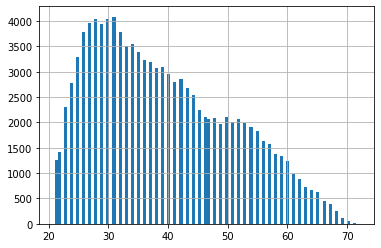

In [19]:
data[NUM[1]].hist(bins=100)
print('Количество выбросов',NUM[1],':',len(outliers_iqr(data,NUM,1)))

decline_app_cnt 25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Количество выбросов decline_app_cnt : 18677


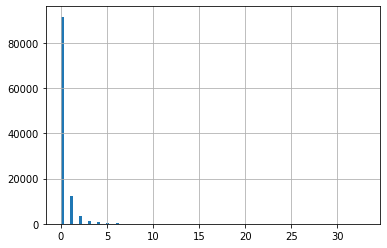

In [20]:
data[NUM[2]].hist(bins=100)
print('Количество выбросов',NUM[2],':',len(outliers_iqr(data,NUM,2)))

score_bki 25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Количество выбросов score_bki : 518


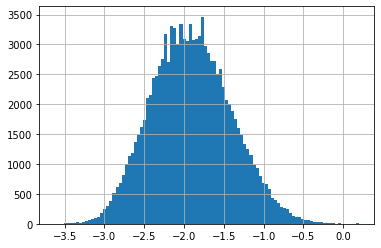

In [21]:
data[NUM[3]].hist(bins=100)
print('Количество выбросов',NUM[3],':',len(outliers_iqr(data,NUM,3)))

bki_request_cnt 25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Количество выбросов bki_request_cnt : 2636


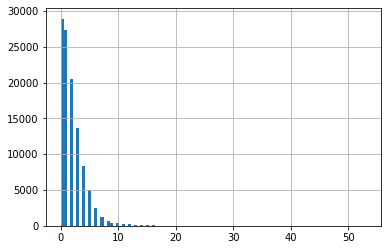

In [22]:
data[NUM[4]].hist(bins=100)
print('Количество выбросов',NUM[4],':',len(outliers_iqr(data,NUM,4)))

region_rating 25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0,  Границы выбросов: [35.0, 75.0].
Количество выбросов region_rating : 17917


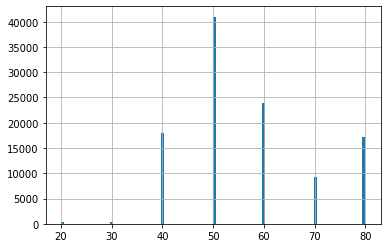

In [23]:
data[NUM[5]].hist(bins=100)
print('Количество выбросов',NUM[5],':',len(outliers_iqr(data,NUM,5)))

home_address 25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Количество выбросов home_address : 0


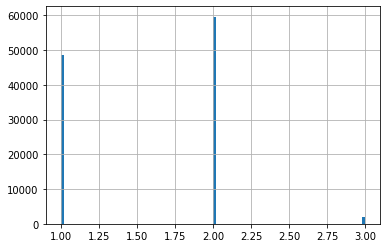

In [24]:
data[NUM[6]].hist(bins=100)
print('Количество выбросов',NUM[6],':',len(outliers_iqr(data,NUM,6)))

work_address 25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].
Количество выбросов work_address : 0


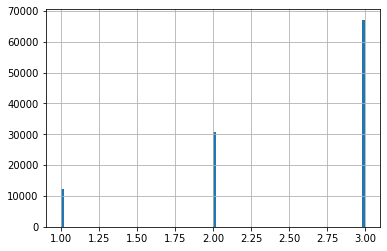

In [25]:
data[NUM[7]].hist(bins=100)
print('Количество выбросов',NUM[7],':',len(outliers_iqr(data,NUM,7)))

income 25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Количество выбросов income : 7000


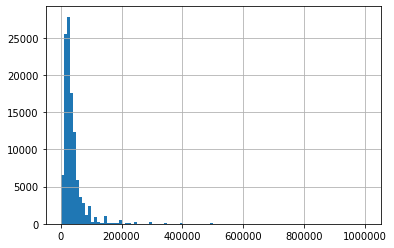

In [26]:
data[NUM[8]].hist(bins=100)
print('Количество выбросов',NUM[8],':',len(outliers_iqr(data,NUM,8)))

sna 25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Количество выбросов sna : 17481


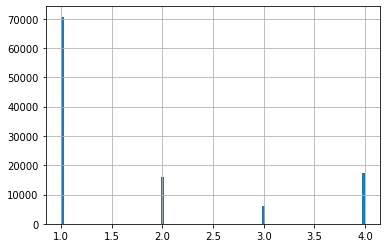

In [27]:
data[NUM[9]].hist(bins=100)
print('Количество выбросов',NUM[9],':',len(outliers_iqr(data,NUM,9)))

first_time 25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].
Количество выбросов first_time : 0


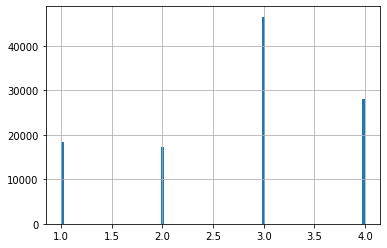

In [28]:
data[NUM[10]].hist(bins=100)
print('Количество выбросов',NUM[10],':',len(outliers_iqr(data,NUM,10)))

# Избавимся от всех выбросов 

In [29]:
del_col = [
    'score_bki',
    'bki_request_cnt',
    'region_rating',
    'income',
    'sna']
for col in del_col:
    outliers(data[col])

D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## Проверим данные на дубликат

In [30]:
# отбрасываем неуникальные строки
df_dedupped = data.drop('client_id', axis=1).drop_duplicates()

# сравниваем формы старого и нового наборов
print(data.shape)
print(df_dedupped.shape)

(110148, 26)
(110148, 25)


Дубликатов нет поэтому двигаемся дальше 

# Оценка корреляций

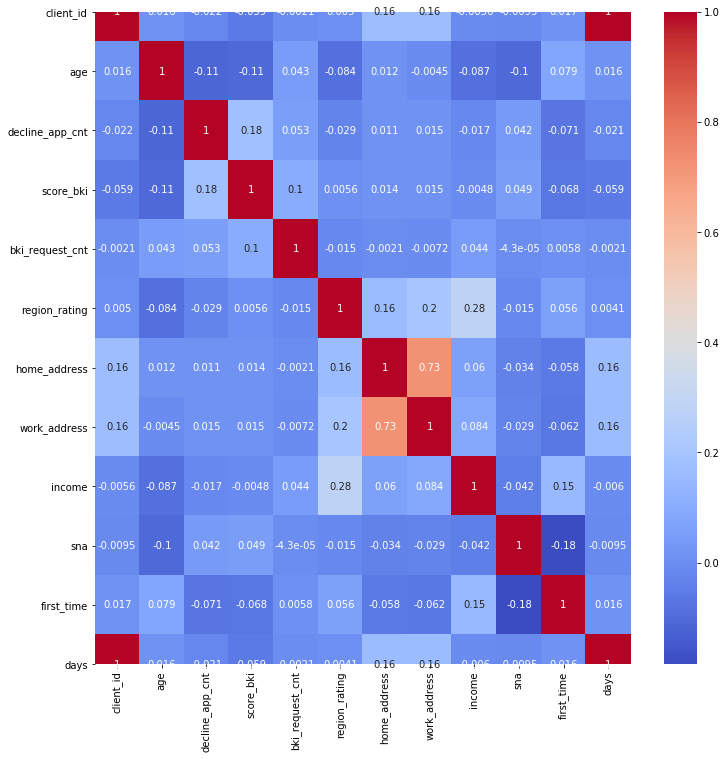

In [31]:
correlation = data[NUM].corr()
plt.figure(figsize = (12, 12))
sns.heatmap(correlation,annot = True,cmap = 'coolwarm')

Наиболее скорелированнй признак: адресс дома и адресс работы 

# Значимость непрерывных переменных

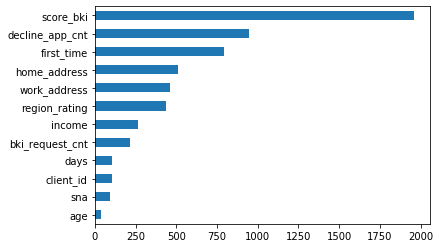

In [32]:
imp_num = Series(f_classif(data[NUM],data['default'])[0], index = NUM)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#### По графику можно сразу увидеть наиболее значимые переменные 

# Бинарные переменные

In [33]:
data_del = data

In [34]:
label_encoder = LabelEncoder()

for column in BIN:
    data_del[column] = label_encoder.fit_transform(data_del[column])
    
# убедимся в преобразовании    
data_del.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,foreign_passport,sample,default,days,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,education_nan
0,74835,2014-03-22,1,29,1,1,0,0,-2.271884,3,...,0,0,0,80,0,1,0,0,0,0
1,17527,2014-01-24,0,39,0,0,5,0,-1.504999,2,...,0,0,0,23,0,0,0,1,0,0
2,75683,2014-03-23,1,50,1,1,0,0,-1.691339,1,...,1,0,0,81,0,0,0,0,1,0
3,26883,2014-02-03,1,56,0,0,0,0,-2.374182,1,...,0,0,0,33,0,0,0,1,0,0
4,28862,2014-02-04,0,38,0,0,0,0,-2.487502,0,...,0,0,0,34,0,1,0,0,0,0


Преобразуем данные у который были выбросы к логарифмическому виду + age

In [35]:
data_del['age'] = np.log(data['age'] + 1)

In [36]:
data_del['decline_app_cnt'] = np.log(data_del['decline_app_cnt'] + 1)

In [37]:
data_del['bki_request_cnt'] = np.log(data_del['bki_request_cnt'] + 1)

In [38]:
data_del['income'] = np.log(data_del['income'] + 1)

# ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

In [39]:
# Преобразуйте этот признак в численный формат, а затем определите важность признаков.
# data_del['education']=label_encoder.fit_transform(data_del['education'])

# imp_cat = Series(mutual_info_classif(data_del[BIN+CAT], data_del['default'],
#                                     discrete_features =True), index = BIN+CAT)
#imp_cat.sort_values(inplace = True)
#imp_cat.plot(kind = 'barh')

In [40]:
data_del.drop(['app_date'], axis=1, inplace=True)

# Подготовка данных к машинному обучению


Стандартизируем числовые переменные:

In [42]:
X_num = StandardScaler().fit_transform(data_del[NUM].values)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [43]:
# Объединяем
X = np.hstack([X_num, data_del[BIN].values])
Y = data_del['default'].values

In [44]:
train_data = data_del.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data = data_del.query('sample == 0').drop(['sample', 'client_id'], axis=1)

#### Подготовка признаков для модели завершена.
#### Разделим данные для обучения следующим образом:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Модель

In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)


D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#  Оценка качества модели

In [47]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [48]:
print_logisitc_metrics(y_test, y_pred)

acc = 0.92 F1-score = 0.02


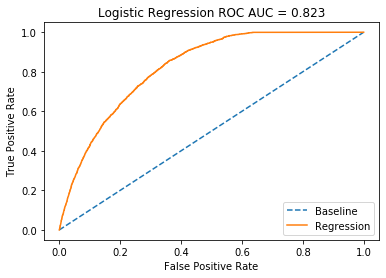

In [49]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Модель херовая надо улучшать 

# РЕГУЛЯРИЗАЦИЯ
Найдем оптимальные параметры для классификатора 

In [50]:
classifier = LogisticRegression(solver='lbfgs',random_state=42)

In [51]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Проверяем модель еще раз и сравниваем результаты

In [52]:
New_model = LogisticRegression(C=3.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
New_model.fit(X_train, y_train)

y_pred_prob = New_model.predict_proba(X_test)[:,1]
y_pred = New_model.predict(X_test)

In [54]:
print_logisitc_metrics(y_test, y_pred)

acc = 0.66 F1-score = 0.30


- Параметры которые предлагал компьютер были мягко говоря не самые лучшие, поэтому путем проб и ошибок были подобраны более лучшие параметры модели 

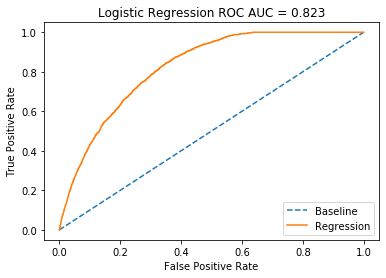

In [55]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Найдем самые важные данные для модели и удалим лишние параметры 

In [62]:
# Тут должен быть код

# Submission

In [56]:
train_data = data_del.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data = data_del.query('sample == 0').drop(['sample', 'client_id'], axis=1)

In [57]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [58]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 23), (73799, 23), (73799, 22), (73799,), (36349, 22))

In [59]:
END_model = LogisticRegression(C=2.0, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
END_model.fit(X_train, y_train)

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
y_pred_prob = END_model.predict_proba(X_test)[:,1]

In [61]:
submit = pd.DataFrame(test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

# Итог
Лучшее значение на Kaggle 0.72032, получилось подбором параметров для модели
Далее закончились попытки 

# Что хотелось бы сделать: 
- По другому организовать фильтрацию выбросов 
- По другому сделать замену nan в education 
- Найти наиболее важные признаки для модели и удалить лишние 
- Найти нормальный алгоритм настройки параметров для модели 
